# Validate `relative_vegetation_change.py`
This notebook is for validating results from the `relative_vegetation_change.py` script. This script is intended to produce relative vegetation change estimates from ALFRESCO outputs. 

The approach taken is to 

1. manually compute relative vegetation here
2. use the script on the same outputs
3. verify that the results from each are the same

## Testing set
The base data used to test this script can be found at `/workspace/Shared/Tech_Projects/Alaska_IEM/project_data/Final_runs/IEM_AR5`.

## Compute relative vegetation change
According to the [SNAP CKAN description](http://ckan.snap.uaf.edu/dataset/alfresco-model-outputs-relative-vegetation-change), relative vegetation change "Counts the number of times a pixel transitions through all replicates and time and divides that value by the total number of layers (replicates * years)"

So to implement this for a single century (100 years) for all replicates (200), relative vegetation change for a single pixel is computed as:

$$n / 100 * 200$$

Where $n$ is the total number of times a pixel transitioned to a different dominant vegetation type.

#### Input data: vegetation change

In [1]:
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import tqdm
from multiprocessing import Pool
from rasterio.plot import show


# setup paths
base_dir = Path("/workspace/Shared/Tech_Projects/Alaska_IEM/project_data/Final_runs/IEM_AR5")
scratch_dir = Path("/atlas_scratch/kmredilla/aalfresco")

# model / scenario for testing
model = "NCAR-CCSM4"
scenario = "rcp45"

In [2]:
temp_veg_fn = f"{model}_{scenario}/Maps/{{}}/Veg_{{}}_{{}}.tif"
year = "2005"
rep = "1"
fp = base_dir.joinpath(temp_veg_fn.format(year, rep, year))

These are only single band files. Unique values:

In [19]:
with rio.open(fp) as src:
    print(np.unique(src.read(1)))

[  0   1   2   3   4   5   6   7   8 255]


Plot as image:

[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]
Plot:


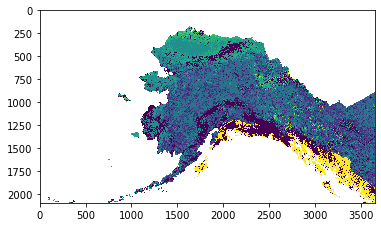

In [22]:
with rio.open(fp) as src:
    temp_arr = src.read(1).astype(float)
    temp_arr[temp_arr == src.meta["nodata"]] = np.nan
    print(np.unique(temp_arr))
    print("Plot:")
    plt.imshow(temp_arr, interpolation="none")

#### Compute relative vegetation change

Compute relative vegetation change for a single model / scenario for a set of years. Use the 20th century as time period so that results may be compared to existing CKAN dataset in addition to results from using the script being evaluated.

In [9]:
eras = {
    "1900-1999": np.arange(1901, 2000),
    "2000-2099": np.arange(2000, 2101),
}

In [10]:
# takes about 30 minutes with 30 cores!
def read_tif(fp):
    with rio.open(fp) as src:
        return src.read(1)

    
# extract the data in prallel
# init empty counting array
total_arr = np.zeros((2100, 3650))
year_range = "1900-1999"

tic = time.perf_counter()

# need to iterate over reps
for rep in np.arange(200):
    # assemble veg arrays for each rep, sum transitions, and add to total arr
    fps = [
        base_dir.joinpath(f"{model}_{scenario}/Maps/{year}/Veg_{rep}_{year}.tif") 
        for year in eras[year_range]
    ]

    with Pool(30) as pool:
        # chunk up printing a little bit, show progress bars for every 20 reps
        if (rep % 20 == 0):
            print(f"working on rep {rep}")
            veg_arrs = [arr for arr in tqdm.tqdm(pool.imap(read_tif, fps), total=len(fps))]
        else:
            veg_arrs = pool.map(read_tif, fps)
    
    # sum the discrete differences along the time
    total_arr += np.sum(
        [np.where(arr != 0, 1, 0) for arr in np.diff(veg_arrs, axis=0)], axis=0
    )

et = round(time.perf_counter() - tic)
print(f"Elapsed time to count all burns: {et}s")

working on rep 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 85.74it/s]


working on rep 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 77.55it/s]


working on rep 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 82.60it/s]


working on rep 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 86.89it/s]


working on rep 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 85.62it/s]


working on rep 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 85.18it/s]


working on rep 120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 78.96it/s]


working on rep 140


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 86.99it/s]


working on rep 160


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 78.30it/s]


working on rep 180


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 55.31it/s]


Elapsed time to count all burns: 1618s


In [11]:
# compute relative vegetation change
change_arr = total_arr.astype(np.float32) / (200 * (len(eras["1900-1999"]) - 1))

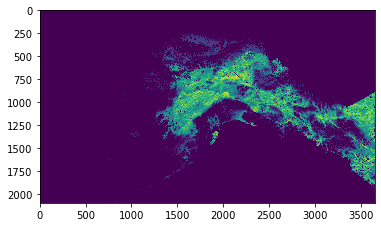

In [12]:
plt.imshow(change_arr, interpolation="none")

Counts of transitions:

(array([6.393196e+06, 2.334720e+05, 1.370360e+05, 1.067030e+05,
        1.615960e+05, 2.437020e+05, 2.213790e+05, 1.226500e+05,
        4.337900e+04, 1.887000e+03]),
 array([  0. ,  34.8,  69.6, 104.4, 139.2, 174. , 208.8, 243.6, 278.4,
        313.2, 348. ]),
 <BarContainer object of 10 artists>)

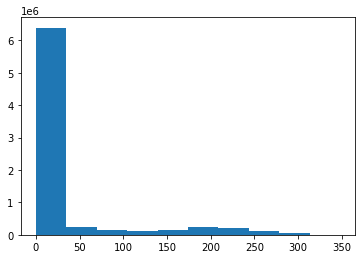

In [13]:
plt.hist(total_arr.flatten())

In [14]:
out_fp = scratch_dir.joinpath(f"alf_rel_veg_manual_{model}_{scenario}_{year_range}.tif")

In [15]:
# to match the script, need to read in mask from veg file and apply it
# get metadata as well
with rio.open(fps[0]) as src:
    mask = src.read_masks(1)
    meta = src.meta.copy()
mask = (mask == 255).astype(int)

In [16]:
mask_value = -9999.0
change_arr[mask == 0] = mask_value

In [17]:
# update metadata
meta.update({"dtype": "float32", "nodata": mask_value, "compress": "lzw"})

# rounded to 4 decimal places in script
with rio.open(out_fp, "w", **meta) as dst:
    dst.write(np.around(change_arr, 4), 1)

## Compute using `alfresco_relative_vegetation_change.py` script

Now apply the `alfresco_relative_vegetation_change.py` to the same model / scenario and years.

In [38]:
maps_path = base_dir.joinpath(f"{model}_{scenario}/Maps/")
ncores = "60"
begin_year = "1900"
end_year = "1999"
output_filename = scratch_dir.joinpath(f"alf_rel_veg_test_{model}_{scenario}_{begin_year}_{end_year}.tif")

In [39]:
# takes over 25 minutes with 60 cores :/
script_run = os.system((
    "cd "
    "../bin/ "
    "&& "
    "python " 
    "alfresco_relative_vegetation_change.py "
    "-p "
    f"{maps_path} "
    "-o "
    f"{output_filename} "
    "-nc "
    f"{ncores} "
    "-by "
    f"{begin_year} "
    "-ey "
    f"{end_year}"
))

Counting transitions for each rep
Summing transitions and computing relative veg change
Writing results to /atlas_scratch/kmredilla/aalfresco/alf_rel_veg_test_NCAR-CCSM4_rcp45_1900_1999.tif...done, total time: 25.1m


## Compare the results

Compare the results from both approaches:

In [40]:
with rio.open(out_fp) as src1:
    with rio.open(output_filename) as src2:
        print("Relative vegetation arrays match: ", np.all(src1.read(1) == src2.read(1)))

Relative vegetation arrays match:  True


Great, looks like the script is valid.